In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [86]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
#client = Client(cluster) # with distributed cluster

In [3]:
client

Client Scheduler: tcp://127.0.0.1:37370 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


In [4]:
root_path = '/home/datawork-lops-osi/slgentil/croco/jetn/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'

In [5]:
df = dd.read_csv(glob(root_path+run+'t1/float.????'), 
                 names=['id','time','xgrid','ygrid','zgrid','depth','temp','u','v','dudt','dvdt','pres'],
                 delim_whitespace=True)#.persist()
dxy = int(run[run.find('km')-1])
df['x'] = df.xgrid*dxy
df['y'] = df.ygrid*dxy
df = df.persist()
df.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
0,7161,1500.0069,196.40944,541.79652,50.0,-0.935944,25.886666,0.058079,-0.105506,-5.820925e-08,3.420817e-07,-8.260263,785.63776,2167.18608
1,7162,1500.0069,196.40937,543.30184,50.0,-0.940022,25.885229,0.057283,-0.101750,-2.034746e-08,3.515808e-07,-8.300321,785.63748,2173.20736
2,7163,1500.0069,196.40946,544.80716,50.0,-0.944117,25.884374,0.058512,-0.097537,-1.201106e-09,3.599363e-07,-8.340519,785.63784,2179.22864
3,7164,1500.0069,196.40961,546.31250,50.0,-0.948345,25.884627,0.060480,-0.093268,-1.958836e-08,3.627984e-07,-8.381996,785.63844,2185.25000
4,7165,1500.0069,196.40971,547.81780,50.0,-0.952706,25.885603,0.061626,-0.089432,-6.096121e-08,3.575484e-07,-8.424740,785.63884,2191.27120


In [6]:
xmin = df['x'].min().compute()
xmax = df['x'].max().compute()
ymin = df['y'].min().compute()
ymax = df['y'].max().compute()

In [12]:
print(xmin,xmax,ymin,ymax)
np.around(ymax)

1.56944452 1026.69668 456.34708 2598.9352


2599.0

In [7]:
dt = (df.groupby('id').time.max()-df.groupby('id').time.min()).compute() # durée de vie de chaque flotteur

In [8]:
Lost = dt[np.around(dt)<100.] 

In [9]:
print(np.array(Lost.index.sort_values())) # liste des flotteurs perdus eau cours des 100 jours (1500j à 1600j)

[   1   77  269  456  674  756  965 1001 1012 1045 1046 1068 1187 1191
 1297 1360 1425 1497 1563 1686 1709 1739 1896 1959 1963 2154 2174 2221
 2252 2276 2287 2293 2355 2357 2361 2465 2472 2476 2483 2577 2603 2612
 2790 2794 2808 2876 2903 2920 3068 3090 3135 3160 3180 3198 3212 3217
 3222 3247 3277 3325 3363 3383 3388 3394 3399 3403 3407 3442 3475 3479
 3482 3485 3498 3499 3504 3505 3518 3578 3678 3679 3742 3749 3784 3811
 3831 3985 3998 4003 4011 4019 4036 4060 4076 4122 4129 4160 4272 4278
 4291 4322 4344 4411 4537 4538 4543 4545 4580 4599 4600 4603 4648 4662
 4668 4719 4742 4755 4841 4883 4907 4922 4928 4944 4949 4953 4963 4964
 4974 4990 5014 5145 5150 5164 5180 5188 5210 5228 5236 5241 5266 5283
 5316 5325 5332 5504 5507 5521 5528 5530 5532 5534 5545 5558 5560 5563
 5564 5565 5567 5571 5581 5587 5595 5619 5631 5649 5660 5664 5718 5754
 5768 5787 5824 5825 5829 5832 5834 5862 5863 5870 5887 5893 5895 5904
 5906 5912 5953 6058 6063 6091 6095 6100 6106 6130 6141 6147 6155 6162
 6177 

In [9]:
df_pd = df.compute() # si passage directement en pandas voulu

In [11]:
#del(df_pd)

### Mean currents with floats

In [10]:
dt_bin = 1
t_bins = np.arange(1500., 1601., dt_bin)
t_id = pd.IntervalIndex.from_breaks(t_bins)
#df_pd['x'] = pd.cut(df_pd.xgrid, bins=x_bins)
df['t_bins'] = df['time'].map_partitions(pd.cut, bins=t_bins)
df.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y,t_bins
0,7161,1500.0069,196.40944,541.79652,50.0,-0.935944,25.886666,0.058079,-0.105506,-5.820925e-08,3.420817e-07,-8.260263,785.63776,2167.18608,"(1500.0, 1501.0]"
1,7162,1500.0069,196.40937,543.30184,50.0,-0.940022,25.885229,0.057283,-0.101750,-2.034746e-08,3.515808e-07,-8.300321,785.63748,2173.20736,"(1500.0, 1501.0]"
2,7163,1500.0069,196.40946,544.80716,50.0,-0.944117,25.884374,0.058512,-0.097537,-1.201106e-09,3.599363e-07,-8.340519,785.63784,2179.22864,"(1500.0, 1501.0]"
3,7164,1500.0069,196.40961,546.31250,50.0,-0.948345,25.884627,0.060480,-0.093268,-1.958836e-08,3.627984e-07,-8.381996,785.63844,2185.25000,"(1500.0, 1501.0]"
4,7165,1500.0069,196.40971,547.81780,50.0,-0.952706,25.885603,0.061626,-0.089432,-6.096121e-08,3.575484e-07,-8.424740,785.63884,2191.27120,"(1500.0, 1501.0]"


In [13]:
#Taille de bin 100km:
dbin = 100.
y_bins = np.arange(0., np.around(ymax), dbin)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df['y_bins'] = df['y'].map_partitions(pd.cut, bins=y_bins)
df.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y,t_bins,y_bins
0,7161,1500.0069,196.40944,541.79652,50.0,-0.935944,25.886666,0.058079,-0.105506,-5.820925e-08,3.420817e-07,-8.260263,785.63776,2167.18608,"(1500.0, 1501.0]","(2100.0, 2200.0]"
1,7162,1500.0069,196.40937,543.30184,50.0,-0.940022,25.885229,0.057283,-0.101750,-2.034746e-08,3.515808e-07,-8.300321,785.63748,2173.20736,"(1500.0, 1501.0]","(2100.0, 2200.0]"
2,7163,1500.0069,196.40946,544.80716,50.0,-0.944117,25.884374,0.058512,-0.097537,-1.201106e-09,3.599363e-07,-8.340519,785.63784,2179.22864,"(1500.0, 1501.0]","(2100.0, 2200.0]"
3,7164,1500.0069,196.40961,546.31250,50.0,-0.948345,25.884627,0.060480,-0.093268,-1.958836e-08,3.627984e-07,-8.381996,785.63844,2185.25000,"(1500.0, 1501.0]","(2100.0, 2200.0]"
4,7165,1500.0069,196.40971,547.81780,50.0,-0.952706,25.885603,0.061626,-0.089432,-6.096121e-08,3.575484e-07,-8.424740,785.63884,2191.27120,"(1500.0, 1501.0]","(2100.0, 2200.0]"


In [15]:
df_t = (df.groupby(['t_bins','y_bins'])['u'].agg(['mean','count','std'])
         .compute().to_xarray().assign_coords(y_bins=y_idx.mid,t_bins=t_id.mid)#.rename('ut_count')
        )

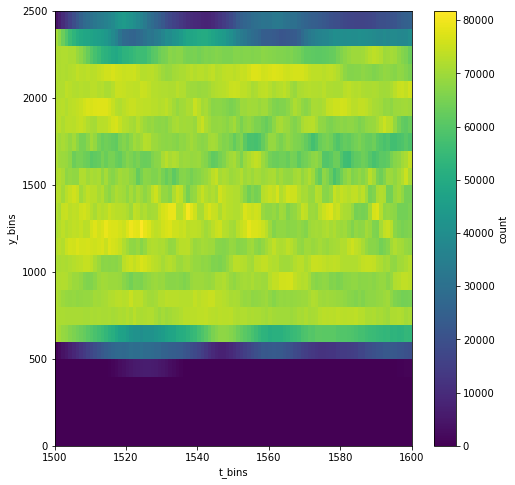

In [16]:
fig,ax = plt.subplots(figsize=(8,8))
df_t['count'].plot(y='y_bins',ax=ax)


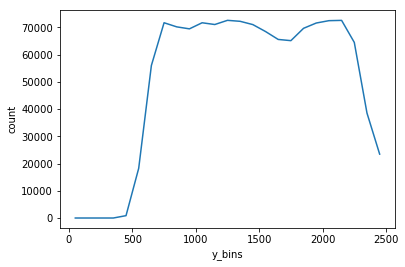

In [17]:
df_t['count'].mean(axis=0).plot()

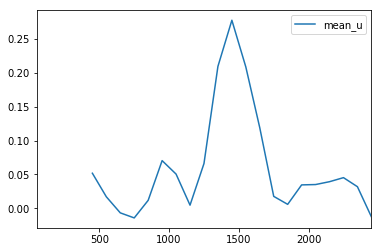

In [18]:
(df.groupby('y_bins')['u'].mean()   # dask
 .compute().to_frame(name='mean_u') # pandas
 .set_index(y_idx.mid).plot() # pandas
)

In [19]:
x_bins = np.arange(0., np.around(xmax), dbin)
x_idy = pd.IntervalIndex.from_breaks(x_bins)
#df_pd['x'] = pd.cut(df_pd.xgrid, bins=x_bins)
df['x_bins'] = df['x'].map_partitions(pd.cut, bins=x_bins)
df.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y,t_bins,y_bins,x_bins
0,7161,1500.0069,196.40944,541.79652,50.0,-0.935944,25.886666,0.058079,-0.105506,-5.820925e-08,3.420817e-07,-8.260263,785.63776,2167.18608,"(1500.0, 1501.0]","(2100.0, 2200.0]","(700.0, 800.0]"
1,7162,1500.0069,196.40937,543.30184,50.0,-0.940022,25.885229,0.057283,-0.101750,-2.034746e-08,3.515808e-07,-8.300321,785.63748,2173.20736,"(1500.0, 1501.0]","(2100.0, 2200.0]","(700.0, 800.0]"
2,7163,1500.0069,196.40946,544.80716,50.0,-0.944117,25.884374,0.058512,-0.097537,-1.201106e-09,3.599363e-07,-8.340519,785.63784,2179.22864,"(1500.0, 1501.0]","(2100.0, 2200.0]","(700.0, 800.0]"
3,7164,1500.0069,196.40961,546.31250,50.0,-0.948345,25.884627,0.060480,-0.093268,-1.958836e-08,3.627984e-07,-8.381996,785.63844,2185.25000,"(1500.0, 1501.0]","(2100.0, 2200.0]","(700.0, 800.0]"
4,7165,1500.0069,196.40971,547.81780,50.0,-0.952706,25.885603,0.061626,-0.089432,-6.096121e-08,3.575484e-07,-8.424740,785.63884,2191.27120,"(1500.0, 1501.0]","(2100.0, 2200.0]","(700.0, 800.0]"


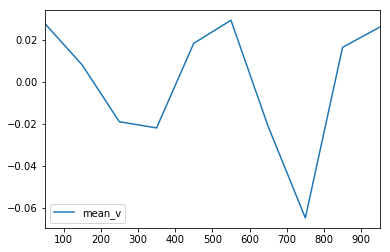

In [20]:
(df.groupby('x_bins')['v'].mean()   # dask
 .compute().to_frame(name='mean_v') # pandas
 .set_index(x_idy.mid).plot() # pandas
)

In [21]:
df['U'] = np.sqrt(df['u']**2+df['v']**2)
df['U2'] = df['u']**2+df['v']**2
df.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y,t_bins,y_bins,x_bins,U,U2
0,7161,1500.0069,196.40944,541.79652,50.0,-0.935944,25.886666,0.058079,-0.105506,-5.820925e-08,3.420817e-07,-8.260263,785.63776,2167.18608,"(1500.0, 1501.0]","(2100.0, 2200.0]","(700.0, 800.0]",0.120435,0.014505
1,7162,1500.0069,196.40937,543.30184,50.0,-0.940022,25.885229,0.057283,-0.101750,-2.034746e-08,3.515808e-07,-8.300321,785.63748,2173.20736,"(1500.0, 1501.0]","(2100.0, 2200.0]","(700.0, 800.0]",0.116766,0.013634
2,7163,1500.0069,196.40946,544.80716,50.0,-0.944117,25.884374,0.058512,-0.097537,-1.201106e-09,3.599363e-07,-8.340519,785.63784,2179.22864,"(1500.0, 1501.0]","(2100.0, 2200.0]","(700.0, 800.0]",0.113741,0.012937
3,7164,1500.0069,196.40961,546.31250,50.0,-0.948345,25.884627,0.060480,-0.093268,-1.958836e-08,3.627984e-07,-8.381996,785.63844,2185.25000,"(1500.0, 1501.0]","(2100.0, 2200.0]","(700.0, 800.0]",0.111161,0.012357
4,7165,1500.0069,196.40971,547.81780,50.0,-0.952706,25.885603,0.061626,-0.089432,-6.096121e-08,3.575484e-07,-8.424740,785.63884,2191.27120,"(1500.0, 1501.0]","(2100.0, 2200.0]","(700.0, 800.0]",0.108608,0.011796


In [22]:
#df_pd.groupby('y')['u'].mean().to_frame(name='mean_dxdt').set_index(y_idx.mid).plot()

In [23]:
#df_pd.groupby('x')['v'].mean().to_frame(name='mean_dydt').set_index(x_idy.mid).plot()

In [24]:
stats = ['mean','count','std']
S = []
for v in ['u','v']:
    _ds = (df.groupby(['x_bins','y_bins'])[v].agg(stats)
         .compute().to_xarray().rename({s: v+'_'+s for s in stats}) #pandas
        )
    S.append(_ds)

In [25]:
df_stats = xr.merge(S).assign_coords(x_bins=x_idy.mid,y_bins=y_idx)#.x_bins.data.mid

In [26]:
ummax = 0.6
ummin = -ummax #-0.2
vmmax = 0.35
vmmin = -vmmax #-0.5
Ummin = 0
Ummax = 0.6

usmax = 0.7
usmin = 0
vsmin = 0
vsmax = 0.85
Usmin = 0
Usmax = 1.1

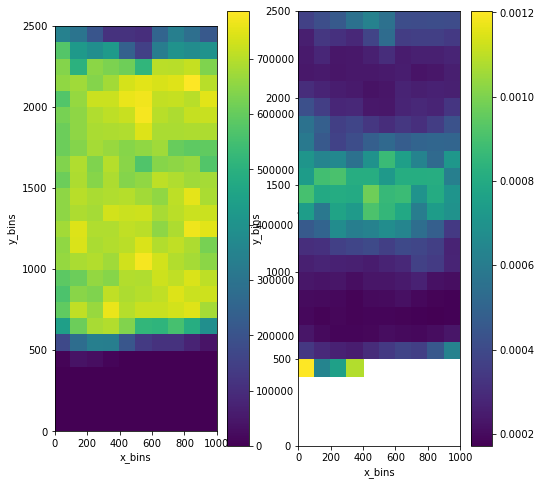

In [27]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,2,1)
df_stats.u_count.plot(ax=ax,y='y_bins')
ax.set_aspect('equal')
ax1 = fig.add_subplot(1,2,2)
(np.sqrt(df_stats.u_std**2+df_stats.v_std**2)/np.sqrt(df_stats.u_count)).plot(ax=ax1,y='y_bins')

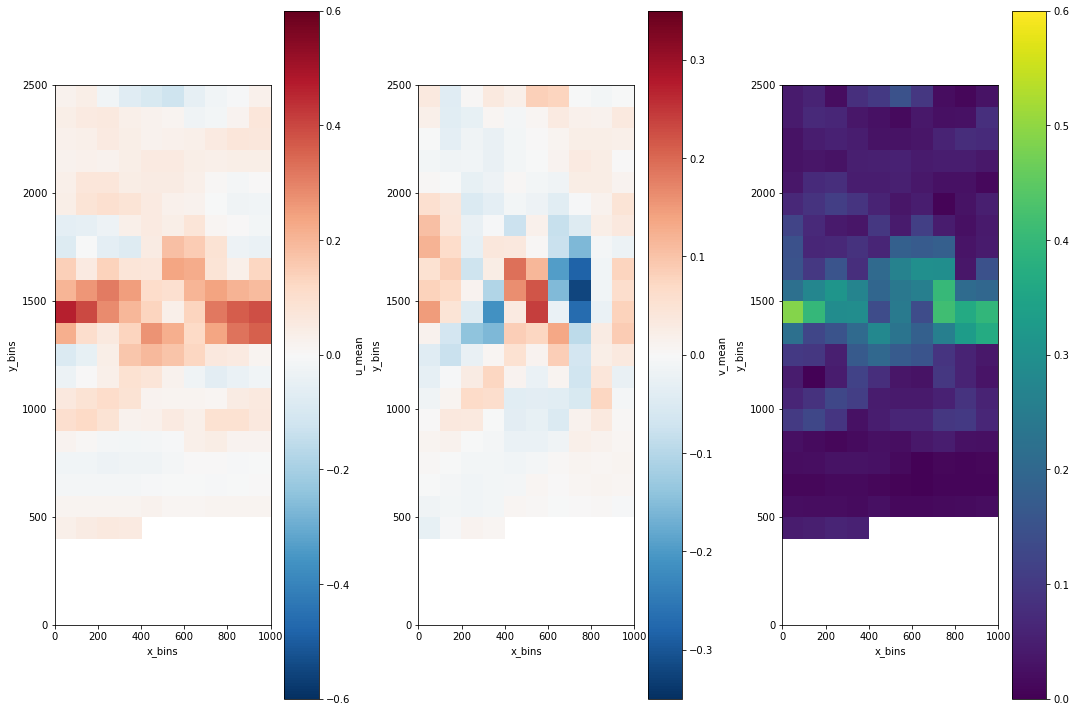

In [29]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,3,1)
df_stats.u_mean.plot(ax=ax,y='y_bins',cmap='RdBu_r',vmin=ummin,vmax=ummax)
ax.set_aspect('equal')
ax1 = fig.add_subplot(1,3,2)
df_stats.v_mean.plot(ax=ax1,y='y_bins',cmap='RdBu_r',vmin=vmmin,vmax=vmmax)
ax1.set_aspect('equal')
ax2 = fig.add_subplot(1,3,3)
(np.sqrt(df_stats.u_mean**2+df_stats.v_mean**2)).plot(ax=ax2,y='y_bins',vmin=Ummin,vmax=Ummax)
ax2.set_aspect('equal')
fig.tight_layout()

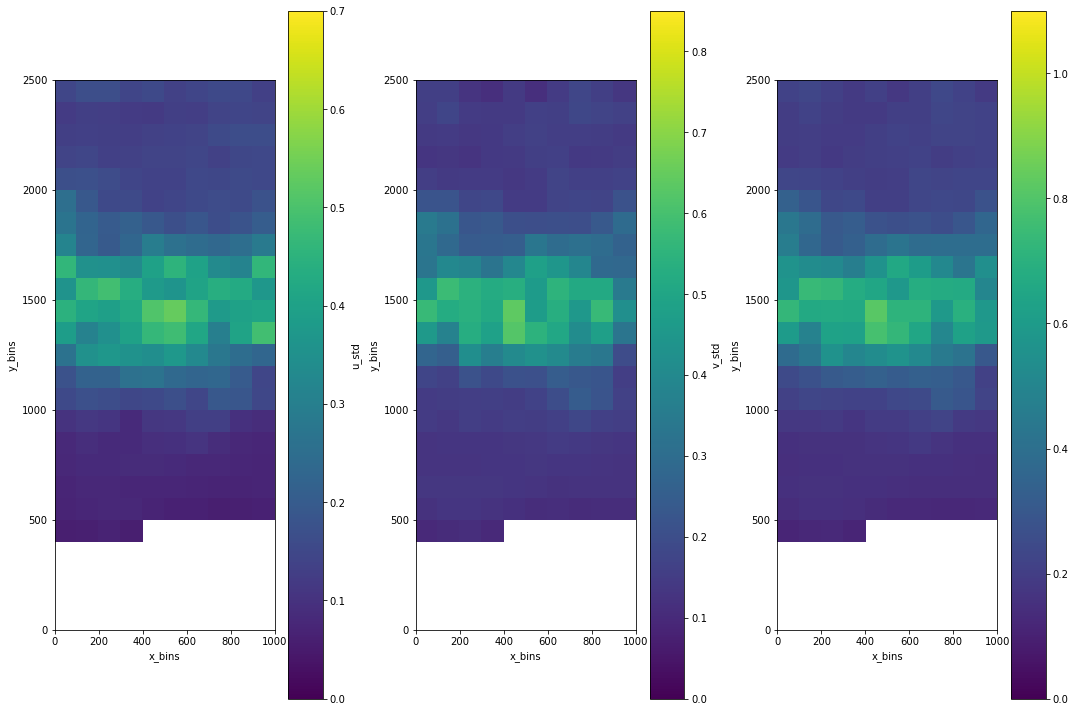

In [30]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,3,1)
df_stats.u_std.plot(ax=ax,y='y_bins',vmin=usmin,vmax=usmax)
ax.set_aspect('equal')
ax1 = fig.add_subplot(1,3,2)
df_stats.v_std.plot(ax=ax1,y='y_bins',vmin=vsmin,vmax=vsmax)
ax1.set_aspect('equal')
ax2 = fig.add_subplot(1,3,3)
(np.sqrt(df_stats.u_std**2+df_stats.v_std**2)).plot(ax=ax2,y='y_bins',vmin=Usmin,vmax=Usmax)
ax2.set_aspect('equal')
fig.tight_layout()

In [36]:
df_meanv = (df.groupby(['x_bins','y_bins'])['v'].mean()
 .compute().to_frame(name='mean_v') #pandas
)

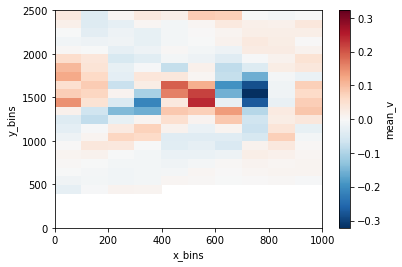

In [48]:
df_meanv.to_xarray().assign_coords(x_bins=x_idy.mid,y_bins=y_idx.mid).mean_v.plot(y='y_bins')

In [9]:
#u_mean = df.groupby(['x','y'])['u'].mean()
v_mean = df_pd.groupby(['x','y'])['v'].mean()

In [10]:
U_mean = df_pd.groupby(['x','y'])['U'].mean()

In [12]:
Umean = U_mean.values.reshape(x_idy.mid.size,y_idx.mid.size)
umean = u_mean.values.reshape(x_idy.mid.size,y_idx.mid.size)
vmean = v_mean.values.reshape(x_idy.mid.size,y_idx.mid.size)

In [13]:
X,Y = np.meshgrid(x_idy.mid,y_idx.mid)

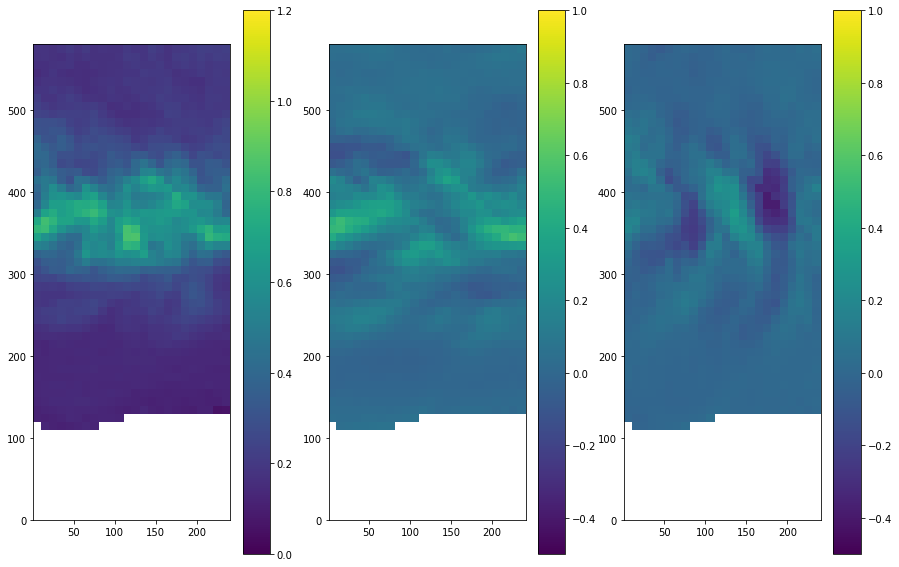

In [21]:
fig =plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,3,1)
cs = ax.pcolor(X,Y,Umean.T,vmax=1.2,vmin=0)
ax.set_aspect('equal')
plt.colorbar(cs)
ax1 = fig.add_subplot(1,3,2)
cs1 = ax1.pcolor(X,Y,umean.T,vmax=1.,vmin=-0.5)
ax1.set_aspect('equal')
plt.colorbar(cs1)
ax2 = fig.add_subplot(1,3,3)
cs2 = ax2.pcolor(X,Y,vmean.T,vmax=1.,vmin=-0.5)
ax2.set_aspect('equal')
plt.colorbar(cs2)

In [22]:
def s2day(s):
    return np.around(s/(24*3600),decimals=4)

In [23]:
idini = df_pd.groupby('time').get_group(1500.0069).sort_values('id').id

In [25]:
idfin = df_pd.groupby('time').get_group(1600).sort_values('id').id

In [26]:
lost = idini[np.isin(idini,idfin)==False]

In [31]:
dbin = 50.
y_bins = np.arange(0., np.around(ymax), dbin)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df['y_bins'] = df['y'].map_partitions(pd.cut, bins=y_bins)
x_bins = np.arange(0., np.around(xmax), dbin)
x_idy = pd.IntervalIndex.from_breaks(x_bins)
#df_pd['x'] = pd.cut(df_pd.xgrid, bins=x_bins)
df['x_bins'] = df['x'].map_partitions(pd.cut, bins=x_bins)

In [32]:
stats = ['mean','count','std']
S = []
for v in ['u','v']:
    _ds = (df.groupby(['x_bins','y_bins'])[v].agg(stats)
         .compute().to_xarray().rename({s: v+'_'+s for s in stats}) #pandas
        )
    S.append(_ds)

df_stats = xr.merge(S).assign_coords(x_bins=x_idy.mid,y_bins=y_idx)

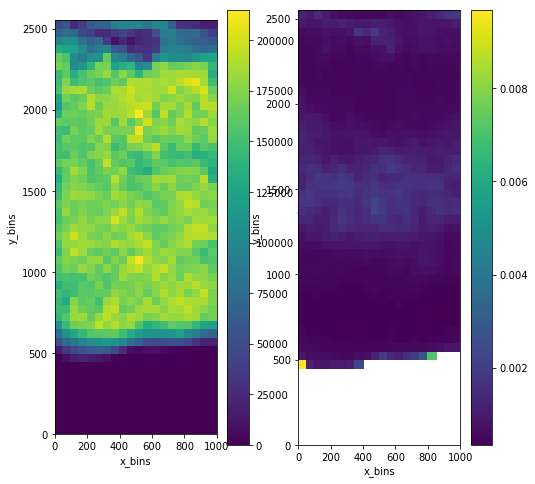

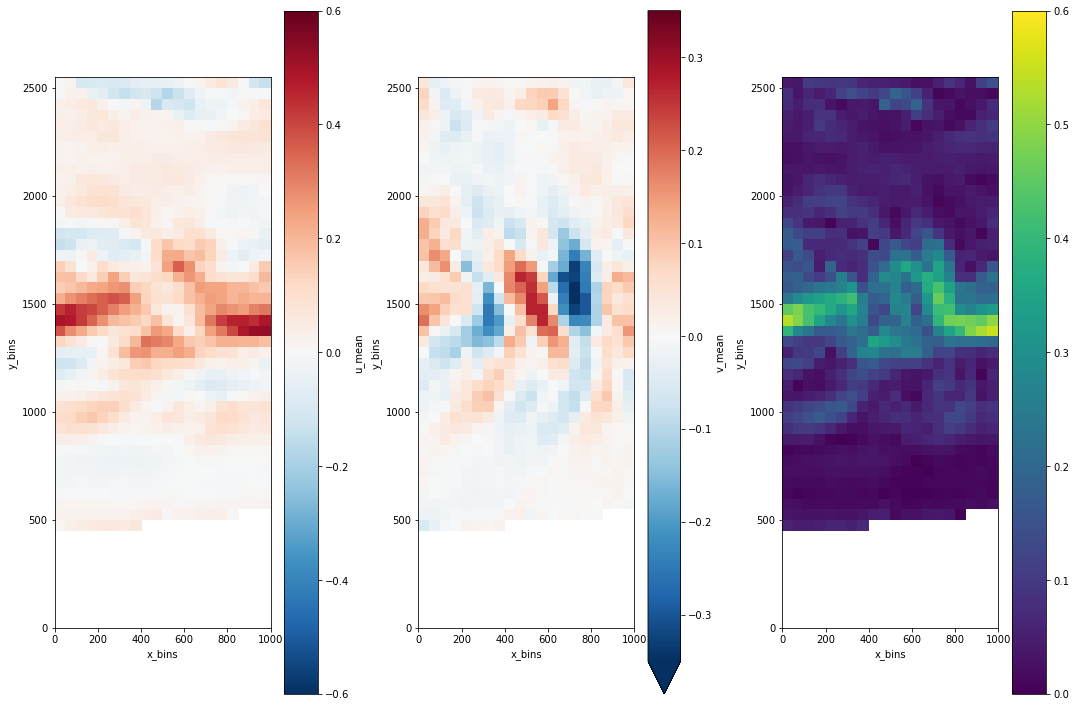

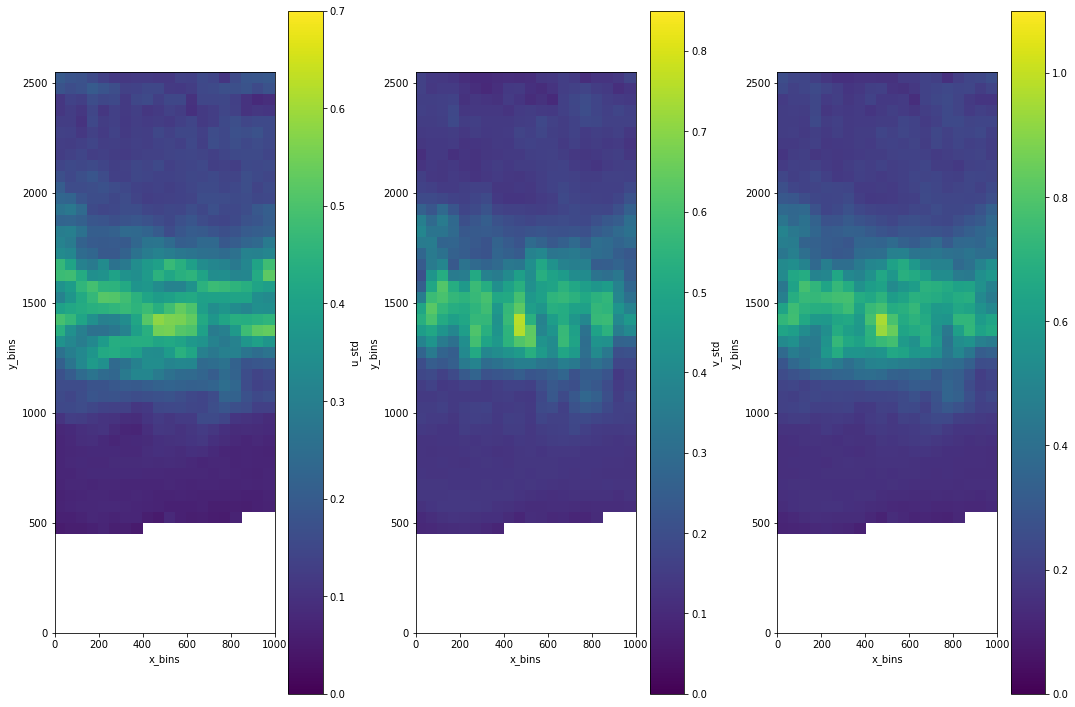

In [34]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,2,1)
df_stats.u_count.plot(ax=ax,y='y_bins')
ax.set_aspect('equal')
ax1 = fig.add_subplot(1,2,2)
(np.sqrt(df_stats.u_std**2+df_stats.v_std**2)/np.sqrt(df_stats.u_count)).plot(ax=ax1,y='y_bins')
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,3,1)
df_stats.u_mean.plot(ax=ax,y='y_bins',cmap='RdBu_r',vmin=ummin,vmax=ummax)
ax.set_aspect('equal')
ax1 = fig.add_subplot(1,3,2)
df_stats.v_mean.plot(ax=ax1,y='y_bins',cmap='RdBu_r',vmin=vmmin,vmax=vmmax)
ax1.set_aspect('equal')
ax2 = fig.add_subplot(1,3,3)
(np.sqrt(df_stats.u_mean**2+df_stats.v_mean**2)).plot(ax=ax2,y='y_bins',vmin=Ummin,vmax=Ummax)
ax2.set_aspect('equal')
fig.tight_layout()
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,3,1)
df_stats.u_std.plot(ax=ax,y='y_bins',vmin=usmin,vmax=usmax)
ax.set_aspect('equal')
ax1 = fig.add_subplot(1,3,2)
df_stats.v_std.plot(ax=ax1,y='y_bins',vmin=vsmin,vmax=vsmax)
ax1.set_aspect('equal')
ax2 = fig.add_subplot(1,3,3)
(np.sqrt(df_stats.u_std**2+df_stats.v_std**2)).plot(ax=ax2,y='y_bins',vmin=Usmin,vmax=Usmax)
ax2.set_aspect('equal')
fig.tight_layout()

In [35]:
dbin = 10.
y_bins = np.arange(0., np.around(ymax), dbin)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df['y_bins'] = df['y'].map_partitions(pd.cut, bins=y_bins)
x_bins = np.arange(0., np.around(xmax), dbin)
x_idy = pd.IntervalIndex.from_breaks(x_bins)
#df_pd['x'] = pd.cut(df_pd.xgrid, bins=x_bins)
df['x_bins'] = df['x'].map_partitions(pd.cut, bins=x_bins)

In [36]:
stats = ['mean','count','std']
S = []
for v in ['u','v']:
    _ds = (df.groupby(['x_bins','y_bins'])[v].agg(stats)
         .compute().to_xarray().rename({s: v+'_'+s for s in stats}) #pandas
        )
    S.append(_ds)
df_stats = xr.merge(S).assign_coords(x_bins=x_idy.mid,y_bins=y_idx)

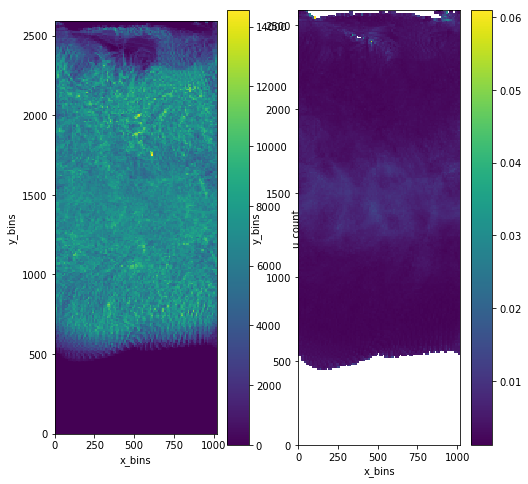

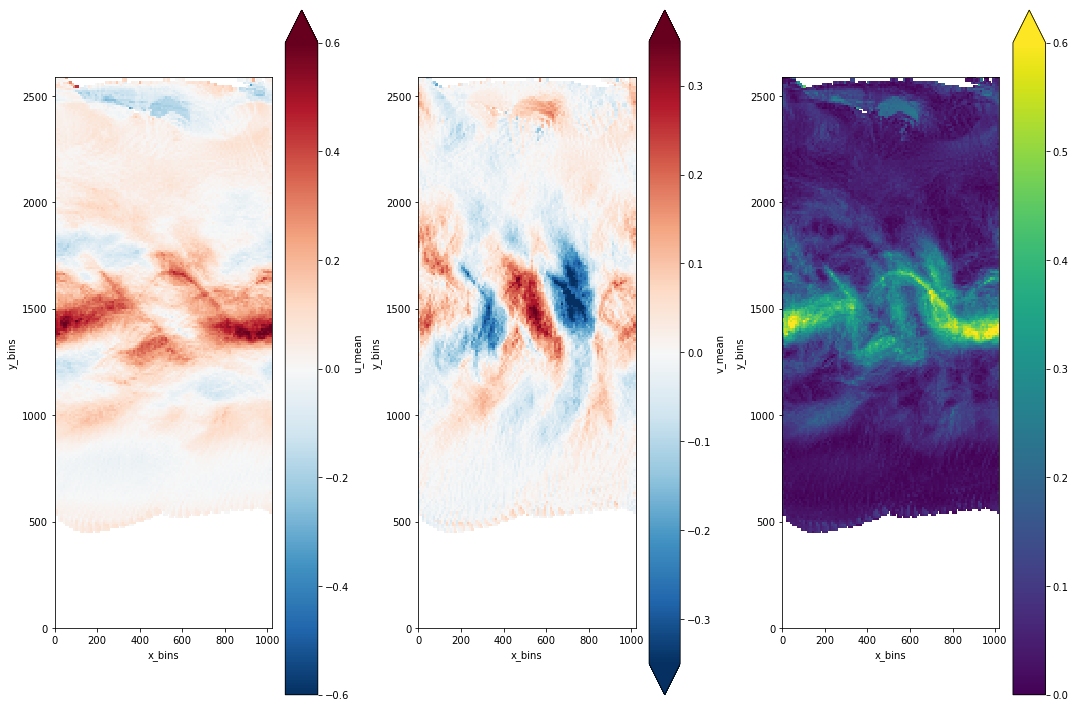

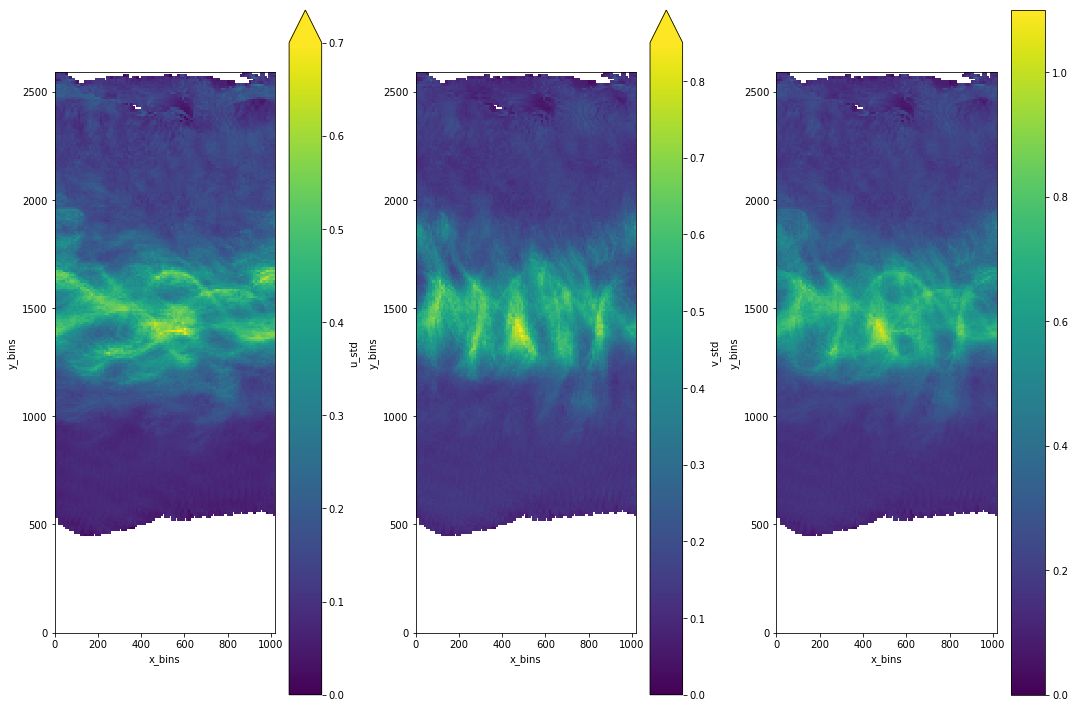

In [37]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,2,1)
df_stats.u_count.plot(ax=ax,y='y_bins')
ax.set_aspect('equal')
ax1 = fig.add_subplot(1,2,2)
(np.sqrt(df_stats.u_std**2+df_stats.v_std**2)/np.sqrt(df_stats.u_count)).plot(ax=ax1,y='y_bins')
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,3,1)
df_stats.u_mean.plot(ax=ax,y='y_bins',cmap='RdBu_r',vmin=ummin,vmax=ummax)
ax.set_aspect('equal')
ax1 = fig.add_subplot(1,3,2)
df_stats.v_mean.plot(ax=ax1,y='y_bins',cmap='RdBu_r',vmin=vmmin,vmax=vmmax)
ax1.set_aspect('equal')
ax2 = fig.add_subplot(1,3,3)
(np.sqrt(df_stats.u_mean**2+df_stats.v_mean**2)).plot(ax=ax2,y='y_bins',vmin=Ummin,vmax=Ummax)
ax2.set_aspect('equal')
fig.tight_layout()
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,3,1)
df_stats.u_std.plot(ax=ax,y='y_bins',vmin=usmin,vmax=usmax)
ax.set_aspect('equal')
ax1 = fig.add_subplot(1,3,2)
df_stats.v_std.plot(ax=ax1,y='y_bins',vmin=vsmin,vmax=vsmax)
ax1.set_aspect('equal')
ax2 = fig.add_subplot(1,3,3)
(np.sqrt(df_stats.u_std**2+df_stats.v_std**2)).plot(ax=ax2,y='y_bins',vmin=Usmin,vmax=Usmax)
ax2.set_aspect('equal')
fig.tight_layout()

### Nombre de flotteurs par bins (et pas de temps): 

In [74]:
def flt_mean(t,var):
    #dfi = df_pd.groupby('time').get_group(t)
    #dfi['Usq'] = dfi.U**2
    groups = dfi.groupby(['x_bins','y_bins'])
    mean = groups[var].mean()
    meansq = groups['Usq'].mean()
    te = mean.copy()
    count = te.fillna(0)
    count[np.isnan(te)==False] = groups.id.count()    
    return count, mean, meansq
def err(t,var,Mean):
    count,mean,meansq = flt_mean(t,var)
    error = np.sqrt(np.abs(meansq-Mean**2)/count)
    return error

In [ ]:
def flts_counts(var):
    varsq = var + 'sq'
    df[varsq] = (df.var**2).compute()
    groups = df.groupby(['x_bins','y_bins'])
    mean = groups[var].mean()
    mean_real = df.var.mean().compute()
    meansq = groups[varsq].mean()

In [38]:
count,mean,meansq = flt_mean(1500+s2day(600*6*24*10),'U')


/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
meansq[np.isnan(meansq/count)==False]

x               y             
(1.0, 11.0]     (170.0, 180.0]    0.021622
                (180.0, 190.0]    0.063231
                (190.0, 200.0]    0.055340
                (200.0, 210.0]    0.019864
                (210.0, 220.0]    0.017017
                                    ...   
(241.0, 251.0]  (500.0, 510.0]    0.013787
                (510.0, 520.0]    0.017748
                (520.0, 530.0]    0.020258
                (530.0, 540.0]    0.019838
                (540.0, 550.0]    0.023954
Name: Usq, Length: 1082, dtype: float64

In [75]:
error = err(1500+s2day(600*6*24*10),'U',1)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [79]:
Count = count.values.reshape(x_bins.size-1,y_bins.size-1)
Mean = mean.values.reshape(x_bins.size-1,y_bins.size-1)
Err = error.values.reshape(x_bins.size-1,y_bins.size-1)

### Mean currents model

In [54]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=['surf'], 
                chunk_time={'his': 1, 'surf': 1}, grid_params=gparams)

In [55]:
ds = r['surf']#.assign_coords(time=ds.time_counter)

In [159]:
dsi = ds.assign_coords(time=ds.time_counter).sel(time=slice(1500,1600)).isel(s_rho_slice0=0)
dsi = dsi.assign_coords(x_rho=dsi.x_rho*dxy,y_rho=dsi.y_rho*dxy,x_u=dsi.x_u*dxy,y_v=dsi.y_v*dxy)

In [160]:
urho = 0.5*(dsi.u.roll(x_u=-1,roll_coords=False)+dsi.u)
urho.values[:,:,-1] = dsi.u.values[:,:,-1]
urho = xr.concat([urho,dsi.u[:,:,0]],dim='x_u').assign_coords(x_u=dsi.x_rho.values).rename({'x_u':'x_rho'})

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/xarray/core/dataarray.py:2727: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


In [161]:
dsi = dsi.assign(u_rho=urho)

In [162]:
vrho = 0.5*(dsi.v.roll(y_v=-1,roll_coords=False)+dsi.v)
vrho.values[:,-1,:] = dsi.v.values[:,-1,:]
vrho = xr.concat([vrho,dsi.v[:,0,:]],dim='y_v').assign_coords(y_v=dsi.y_rho.values).rename({'y_v':'y_rho'})

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/xarray/core/dataarray.py:2727: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


In [163]:
dsi = dsi.assign(v_rho=vrho)

In [169]:
stats_surf = xr.Dataset({'u_mean_surf' : dsi.u_rho.mean(axis=0).compute(),'v_mean_surf' : dsi.v_rho.mean(axis=0).compute(),
                  #       'U_mean_surf' : np.sqrt(dsi.u_rho.mean(axis=0)**2+dsi.v_rho.mean(axis=0)**2),
                        'u_std_surf' : dsi.u_rho.std(axis=0).compute(),'v_std_surf' : dsi.v_rho.std(axis=0).compute(),
                   #      'U_std_surf' : np.sqrt(dsi.u_rho.std(axis=0)**2+dsi.v_rho.std(axis=0)**2)
                        })

In [170]:
stats_surf

<xarray.Dataset>
Dimensions:       (x_rho: 258, y_rho: 722)
Coordinates:
    eta_rho       (y_rho, x_rho) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    xi_rho        (y_rho, x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
    s_rho_slice0  float32 -0.01
    f             (y_rho, x_rho) float32 0.00010309763 ... 0.00014977805
  * x_rho         (x_rho) int64 0 4 8 12 16 20 ... 1008 1012 1016 1020 1024 1028
  * y_rho         (y_rho) int64 0 4 8 12 16 20 ... 2864 2868 2872 2876 2880 2884
Data variables:
    u_mean_surf   (y_rho, x_rho) float32 -7.430977e-05 ... 0.00059640827
    v_mean_surf   (y_rho, x_rho) float32 -3.25606e-05 ... -3.2158812e-05
    u_std_surf    (y_rho, x_rho) float32 0.005523368 ... 0.0060512265
    v_std_surf    (y_rho, x_rho) float32 0.010072726 0.010088847 ... 0.009755279

In [192]:
ummax = 0.6
ummin = -ummax #-0.2
vmmax = 0.35
vmmin = -vmmax #-0.5
Ummin = 0
Ummax = 0.6

usmax = 0.7
usmin = 0
vsmin = 0
vsmax = 0.85
Usmin = 0
Usmax = 1.1

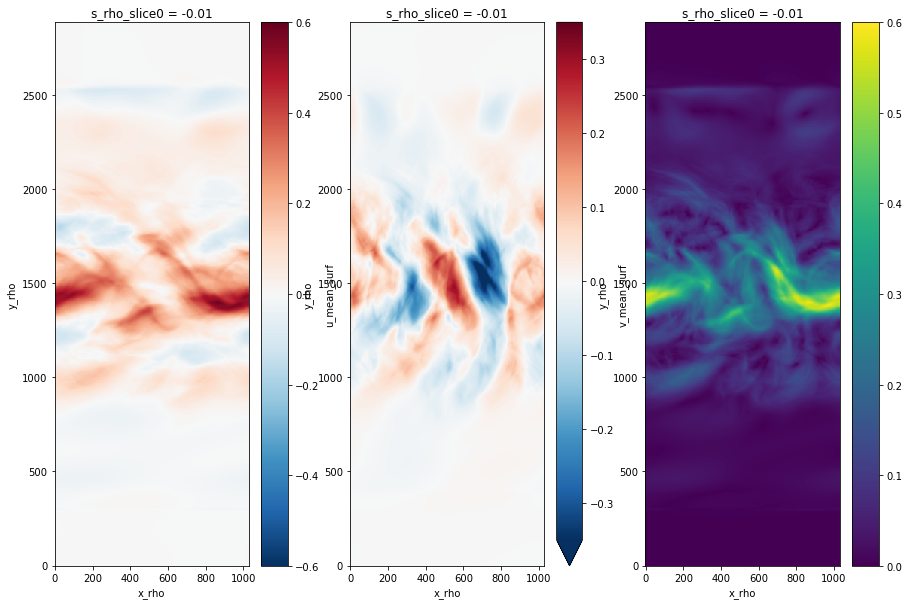

In [193]:
fig = plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,3,1)
stats_surf.u_mean_surf.plot(ax=ax,cmap='RdBu_r',vmin=ummin,vmax=ummax)
ax.set_aspect('equal')
ax1=fig.add_subplot(1,3,2)
stats_surf.v_mean_surf.plot(ax=ax1,cmap='RdBu_r',vmin=vmmin,vmax=vmmax)
ax1.set_aspect('equal')
ax2=fig.add_subplot(1,3,3)
(np.sqrt(stats_surf.u_mean_surf**2+stats_surf.v_mean_surf**2)).plot(ax=ax2,vmin=Ummin,vmax=Ummax)
ax2.set_aspect('equal')


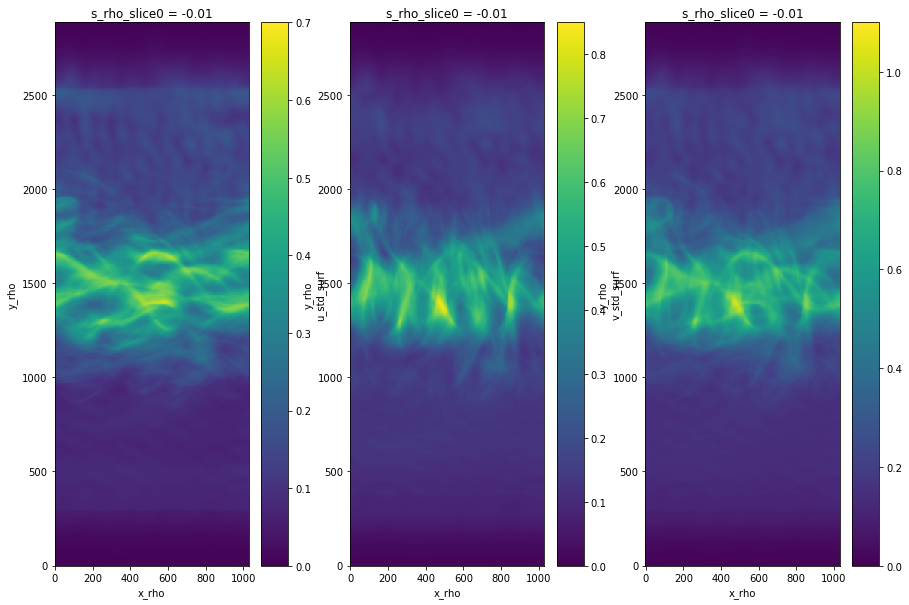

In [190]:
fig = plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,3,1)
stats_surf.u_std_surf.plot(ax=ax,vmin=usmin,vmax=usmax)
ax.set_aspect('equal')
ax1=fig.add_subplot(1,3,2)
stats_surf.v_std_surf.plot(ax=ax1,vmin=vsmin,vmax=vsmax)
ax1.set_aspect('equal')
ax2=fig.add_subplot(1,3,3)
(np.sqrt(stats_surf.u_std_surf**2+stats_surf.v_std_surf**2)).plot(ax=ax2,vmin=Usmin,vmax=Usmax)
ax2.set_aspect('equal')

In [ ]:
### Passage par numpy

In [78]:
def u2rho(var_u):
    [Tp,Mp,L] = var_u.shape
    Lp = L+1
    Lm = L-1
    u_rho = np.zeros((Tp,Mp,Lp))
    u_rho[:,:,1:L]=0.5*(var_u[:,:,0:Lm]+var_u[:,:,1:L])
    u_rho[:,:,0]=u_rho[:,:,1]
    u_rho[:,:,Lp-1]=u_rho[:,:,L-1]
    return u_rho
def v2rho(var_v):
    [Tp,M,Lp] = var_v.shape
    Mp = M+1
    Mm = M-1
    v_rho = np.zeros((Tp,Mp,Lp))
    v_rho[:,1:M,:]=0.5*(var_v[:,0:Mm,:]+var_v[:,1:M,:])
    v_rho[:,0,:]=v_rho[:,1,:]
    v_rho[:,Mp-1,:]=v_rho[:,M-1,:]
    return v_rho

In [ ]:
v_rho = v2rho(dsi.v[:,0,:,:].values)

In [ ]:
u_rho = u2rho(dsi.u[:,0,:,:].values)

In [ ]:
U_rho = np.sqrt(u_rho**2+v_rho**2)

In [ ]:
umean_rho = u_rho.mean(axis=0)
vmean_rho = v_rho.mean(axis=0)
Umean_rho = U_rho.mean(axis=0)

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,3,1)
cs = ax.pcolor(Umean_rho,vmax=2,vmin=0)
plt.colorbar(cs)
ax.set_aspect('equal')
ax1 = fig.add_subplot(1,3,2)
cs1 = ax1.pcolor(umean_rho,vmax=1.5,vmin=-1.)
ax1.set_aspect('equal')
plt.colorbar(cs1)
ax2 = fig.add_subplot(1,3,3)
cs2 = ax2.pcolor(vmean_rho,vmax=1.5,vmin=-1.5)
ax2.set_aspect('equal')
plt.colorbar(cs2)

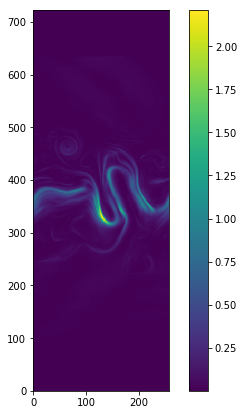

In [63]:
fig,ax = plt.subplots(figsize=(7,7))
cs = ax.pcolor(0.5*(Umean_rho**2))
plt.colorbar(cs)
ax.set_aspect('equal')

In [25]:
umean_surf = dsi.u[:,0,:,:].mean(axis=0)

In [26]:
vmean_surf = dsi.v[:,0,:,:].mean(axis=0)

In [ ]:
v_mean = ds.v[:,0,:,:].mean(axis=0)

In [ ]:
# si cluster
#cluster.close()